## Overland Flow Scratchwork

First get the necessary libraries

In [2]:
import numpy as np
from matplotlib.pyplot import figure


from landlab.components import OverlandFlow
from landlab import RasterModelGrid
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

import math
class FlowResistance():
    def Baptist_2007(self, bed_roughness, drag_coef, veg_den, veg_diam, veg_height, gravity, van_karman, water_depth):
        #The baptist equation 
        Cr1=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) + (np.sqrt(gravity)/van_karman)*np.log(water_depth/veg_height)
        Cr2=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) 
        if (veg_height>=water_depth).all():
            return Cr2
        else:
            return Cr1
        
    def chezy_to_manning(self,water_depth,Chezy):
        #The actual relationship
        n=water_depth**(1/6)/Chezy
        return n
    

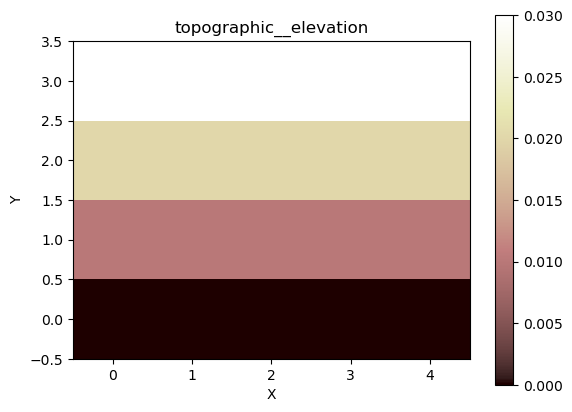

In [3]:
#Define grid
grid = RasterModelGrid((4, 5))

#add topographic values to field
z = grid.node_y*0.01  # a flat surface dipping shallowly south
# create the field:
grid.add_field('node', 'topographic__elevation', z, units='m')

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")



In [4]:
#add surface water depth(1 m everywhere) (We assume initial water depth of 1 m therefore)
a=grid.add_ones("surface_water__depth", at = "node", clobber = True)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

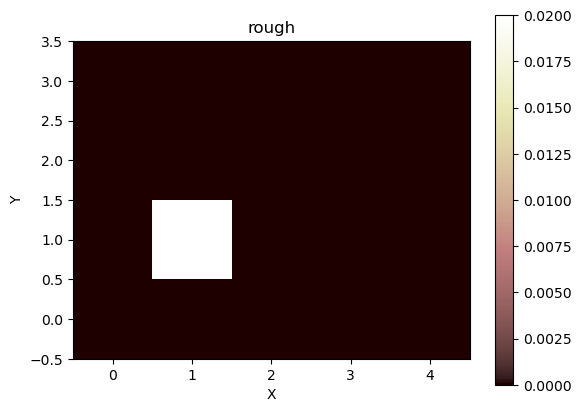

In [24]:
#now add roughness (we need to add initial values, let say n=0.02)
grid.add_zeros("rough",  at = "node", clobber=True)

#create some variation
grid.at_node["rough"][6] = 0.02
#plot roughness
figure('mannings_n')
imshow.imshow_grid_at_node(grid, "rough")

In [14]:
#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()


['surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge',
 'mannings_n']

In [15]:
grid.at_link.keys()

['surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge',
 'mannings_n']

[[ 17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.46461828  17.46461828]]
time: 0.0 [ 1.          1.          1.          1.          1.          1.
  1.03320902  0.9819439   1.03320902  1.          1.          1.0068414
  1.08616821  1.0068414   1.          1.          1.          1.
  1.          1.        ] [ 0.05725862  0.05725862  0.05725862  0.05725862  0.05725862  0.05725862
  0.05676014  0.05754363  0.05676014  0.05725862  0.05725862  0.05715328
  0.05602722  0.05715328  0.05725862  0.05725862  0.05725862  0.05725862
  0.05725862  0.05725862]
[[ 17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.46461828  17.46461828
   17.46461828  17.46461828  17.46461828  17.4

['surface_water__depth',
 'water_surface__gradient',
 'surface_water__discharge',
 'mannings_n']

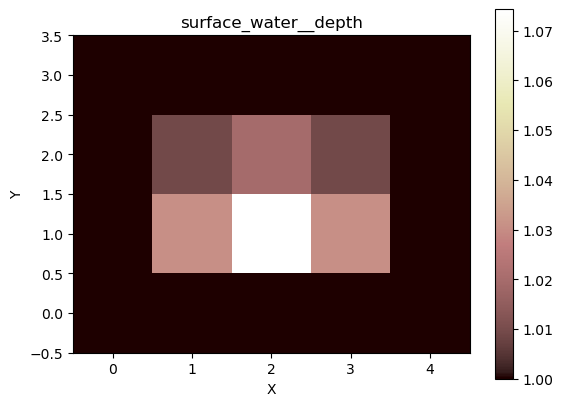

In [30]:

# time parameters
total_time = 600.0  # total simulation time
dt = 10.0  # time step size
#run model one step
a=grid.add_ones("surface_water__depth", at = "node", clobber = True)


#init overland flow model
of = OverlandFlow(grid, mannings_n = "mannings_n", rainfall_intensity=1, steep_slopes=True)
of.run_one_step()

# loop over time steps
for t in np.arange(0.0, total_time, dt):
    a=grid.add_ones("surface_water__depth", at = "node", clobber = True)

    #Call the Flow Resistance class
    fr = FlowResistance()
    water_depth = np.array([a])
    cr = fr.Baptist_2007(bed_roughness=10, drag_coef=1.0, veg_den=4500, veg_diam=0.003, veg_height=0.15, gravity=9.81, van_karman=0.41, water_depth=water_depth)
    #print(cr)

    # update water depth in OverlandFlow model
    of.run_one_step(dt=dt)
    
    # get updated water depth from grid
    water_depth = grid.at_node['surface_water__depth']
    
    # update roughness using updated water depth
    cr = flow_resistance.Baptist_2007(bed_roughness=10, drag_coef=1.0, veg_den=4500, veg_diam=0.003, veg_height=0.15, gravity=9.81, van_karman=0.41, water_depth=water_depth)
    n = fr.chezy_to_manning(water_depth, cr)
    
    # update roughness field in grid
    grid.at_node['rough'] = n
    
    # map updated roughness to links
    r = grid.map_mean_of_link_nodes_to_link('rough')
    
    # update Mannings n field in grid
    grid.at_link['mannings_n'] = r
    
    # print current time
    print('time:', t,water_depth,n)


#plot water depth
figure('water depth')
imshow.imshow_grid_at_node(grid, "surface_water__depth")

grid.at_link.keys()

